In [1]:
import numpy as np

In [2]:
import scipy
import torch

def _spline_window(window_size: int, power: int = 2) -> np.ndarray:
    """Generates a 1-dimensional spline of order 'power' (typically 2), in the designated
    window.
    https://www.wolframalpha.com/input/?i=y%3Dx**2,+y%3D-(x-2)**2+%2B2,+y%3D(x-4)**2,+from+y+%3D+0+to+2

    Args:
        window_size (int): size of the interested window
        power (int, optional): Order of the spline. Defaults to 2.

    Returns:
        np.ndarray: 1D spline
    """
    intersection = int(window_size / 4)
    wind_outer = (abs(2 * (scipy.signal.windows.triang(window_size))) ** power) / 2
    wind_outer[intersection:-intersection] = 0

    wind_inner = 1 - (abs(2 * (scipy.signal.windows.triang(window_size) - 1)) ** power) / 2
    wind_inner[:intersection] = 0
    wind_inner[-intersection:] = 0

    wind = wind_inner + wind_outer
    wind = wind / np.average(wind)
    return wind

def _spline_2d(window_size: int, power: int = 2) -> torch.Tensor:
    """Makes a 1D window spline function, then combines it to return a 2D window function.
    The 2D window is useful to smoothly interpolate between patches.

    Args:
        window_size (int): size of the window (patch)
        power (int, optional): Which order for the spline. Defaults to 2.

    Returns:
        np.ndarray: numpy array containing a 2D spline function
    """
    # Memorization to avoid remaking it for every call
    # since the same window is needed multiple times
    
    wind = _spline_window(window_size, power)
    wind = np.expand_dims(np.expand_dims(wind, 1), 1)  # SREENI: Changed from 3, 3, to 1, 1
    wind = torch.from_numpy(wind * wind.transpose(1, 0, 2))
    return wind

In [3]:
canvas = np.full((8, 8), 0, dtype=float)

p1 = np.full((4,4), 2, dtype=float)
p1_top_left = (0, 0)

p2 = np.full((4,4), 4, dtype=float)
p2_top_left = (0, 2)

canvas

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [4]:
def get_I(patch_top_left: tuple, patch_shape: tuple):
    row, col = patch_top_left
    h, w = patch_shape
    I = np.s_[row : row+h, col : col+w]
    return I

def is_overlap(canvas, I, def_val = -100):
    is_overlap = canvas[I] != def_val
    return is_overlap

def add_patch(canvas, patch, patch_top_left, mode: str):
    I = get_I(patch_top_left, patch.shape)
    ov = is_overlap(canvas, I) # bool mask
    if mode == 'plain_avg':
        canvas[I] = np.where(ov, (patch + canvas[I])/2, patch)
    elif mode == 'max':
        canvas[I] = np.where(ov, np.max(patch + canvas[I]), patch)
    elif mode == 'smooth':
        spline = _spline_2d(window_size = patch.shape[0], power = 2).squeeze(-1)
        canvas[I] += (patch * spline.numpy())
        #canvas[I] = np.where(ov, (patch + canvas[I]) / 2, patch)
    return canvas

In [5]:
add_patch(canvas, p1, p1_top_left, mode='plain_avg')

array([[1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [6]:
add_patch(canvas, p2, p2_top_left, mode='plain_avg')

array([[1. , 1. , 2.5, 2.5, 2. , 2. , 0. , 0. ],
       [1. , 1. , 2.5, 2.5, 2. , 2. , 0. , 0. ],
       [1. , 1. , 2.5, 2.5, 2. , 2. , 0. , 0. ],
       [1. , 1. , 2.5, 2.5, 2. , 2. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ]])

In [6]:
print('canvas\n', canvas)
I = np.s_[0 : 0+h, 2 : 2+w]
p2 = np.full((4, 4), 2)
ov = is_overlap(canvas, I) #4,4 bool mask
print('p2\n', p2)
print('canvas[I]\n', canvas[I])
print('avg')
print((p2 + canvas[I])/2)
canvas[I] = np.where(ov, (p2 + canvas[I])/2, p2)
#print('res', res)
#np.where(ov, p1[is_overlap(canvas, I)] + canvas[I][is_overlap(canvas, I)] , p1)
print('canvas\n', canvas)

canvas
 [[ 7.  7.  7.  7. -1. -1. -1. -1.]
 [ 7.  7.  7.  7. -1. -1. -1. -1.]
 [ 7.  7.  7.  7. -1. -1. -1. -1.]
 [ 7.  7.  7.  7. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]]
p2
 [[2 2 2 2]
 [2 2 2 2]
 [2 2 2 2]
 [2 2 2 2]]
canvas[I]
 [[ 7.  7. -1. -1.]
 [ 7.  7. -1. -1.]
 [ 7.  7. -1. -1.]
 [ 7.  7. -1. -1.]]
avg
[[4.5 4.5 0.5 0.5]
 [4.5 4.5 0.5 0.5]
 [4.5 4.5 0.5 0.5]
 [4.5 4.5 0.5 0.5]]
canvas
 [[ 7.   7.   4.5  4.5  2.   2.  -1.  -1. ]
 [ 7.   7.   4.5  4.5  2.   2.  -1.  -1. ]
 [ 7.   7.   4.5  4.5  2.   2.  -1.  -1. ]
 [ 7.   7.   4.5  4.5  2.   2.  -1.  -1. ]
 [-1.  -1.  -1.  -1.  -1.  -1.  -1.  -1. ]
 [-1.  -1.  -1.  -1.  -1.  -1.  -1.  -1. ]
 [-1.  -1.  -1.  -1.  -1.  -1.  -1.  -1. ]
 [-1.  -1.  -1.  -1.  -1.  -1.  -1.  -1. ]]


In [11]:
p2 = np.full((4, 4), 2)
I = np._s[0 : 0+h, 2 : 2+w]
canvas[I] = p2
canvas

array([[1., 1., 2., 2., 2., 2., 0., 0.],
       [1., 1., 2., 2., 2., 2., 0., 0.],
       [1., 1., 2., 2., 2., 2., 0., 0.],
       [1., 1., 2., 2., 2., 2., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [18]:
spli = _spline_2d(4, power = 2)

/tmp/ipykernel_17127/3926806145.py:17: DeprecationWarning: Importing triang from 'scipy.signal' is deprecated since SciPy 1.1.0 and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.triang' or the convenience function 'scipy.signal.get_window' instead.
  wind_outer = (abs(2 * (scipy.signal.triang(window_size))) ** power) / 2
/tmp/ipykernel_17127/3926806145.py:20: DeprecationWarning: Importing triang from 'scipy.signal' is deprecated since SciPy 1.1.0 and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.triang' or the convenience function 'scipy.signal.get_window' instead.
  wind_inner = 1 - (abs(2 * (scipy.signal.triang(window_size) - 1)) ** power) / 2


In [20]:
spli[:, :, 0]

tensor([[0.0156, 0.2344, 0.2344, 0.0156],
        [0.2344, 3.5156, 3.5156, 0.2344],
        [0.2344, 3.5156, 3.5156, 0.2344],
        [0.0156, 0.2344, 0.2344, 0.0156]], dtype=torch.float64)

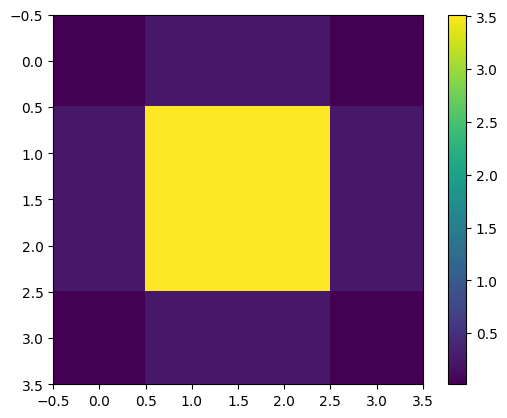

In [19]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(spli[:, :, 0], cmap='viridis')
plt.colorbar()
plt.show()

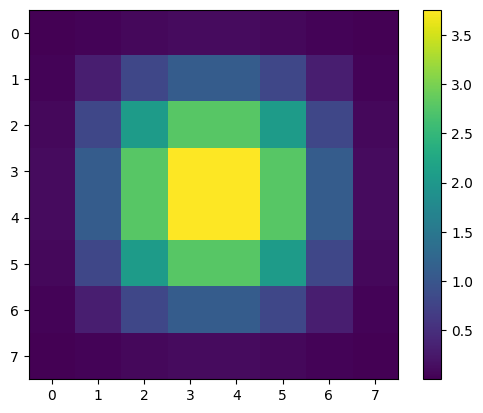

In [15]:
plt.imshow(spli[:, :, 0], cmap='viridis')
plt.colorbar()
plt.show()